In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler


train = pd.read_csv("/content/drive/MyDrive/trainmod.csv", index_col=[0])
test = pd.read_csv("/content/drive/MyDrive/testmod.csv", index_col=[0])

In [ ]:
train.shape

(4828800, 6)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.53.92.90:8470


Number of replicas: 8


In [ ]:
print(train.columns)
feature_cols = ["R","C", "u_in", "u_out"]

Index(['R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')


In [ ]:
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_train = len(train) // n_steps  # Calculate the number of breaths
y_train = train[target_column_name].values[:n_samples_train * n_steps].reshape(-1, n_steps)
X_train = train[feature_cols].values[:n_samples_train * n_steps].reshape(-1, n_steps, n_features)

print(X_train.shape, y_train.shape)

(60360, 80, 4) (60360, 80)


In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
from sklearn.model_selection import train_test_split, GroupKFold, KFold

In [ ]:
from tensorflow import keras

In [ ]:
with tpu_strategy.scope():
    kf = KFold(n_splits=5, shuffle=True, random_state=2023)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        model = keras.models.Sequential([
        layers.InputLayer(input_shape=(n_steps, n_features)),
            keras.layers.Bidirectional(keras.layers.LSTM(300, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(250, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            keras.layers.Dense(50, activation='gelu'),
            keras.layers.Dense(1),
        ])
        model.compile(optimizer="adam", loss="mae")

model.summary()

--------------- > Fold 1 < ---------------
--------------- > Fold 2 < ---------------
--------------- > Fold 3 < ---------------
--------------- > Fold 4 < ---------------
--------------- > Fold 5 < ---------------
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 80, 600)          732000    
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 80, 500)          1702000   
 onal)                                                           
                                                                 
 bidirectional_38 (Bidirecti  (None, 80, 300)          781200    
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 

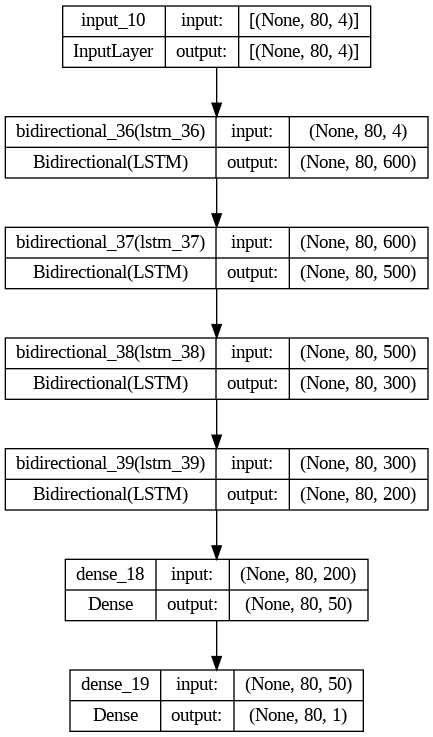

In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
X_train_reshaped = X_train[:, :80, :4]

In [ ]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1e4, decay_rate=1e-5)
cb_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=1024, callbacks=[cb_es, cb_lr])

Epoch 1/200
48/48 [==============================] - 69s 801ms/step - loss: 4.7555 - val_loss: 3.0917 - lr: 0.0010
Epoch 2/200
48/48 [==============================] - 16s 324ms/step - loss: 2.3391 - val_loss: 1.8822 - lr: 9.9885e-04
Epoch 3/200
48/48 [==============================] - 15s 323ms/step - loss: 1.7034 - val_loss: 1.5787 - lr: 9.9770e-04
Epoch 4/200
48/48 [==============================] - 15s 323ms/step - loss: 1.2867 - val_loss: 1.2113 - lr: 9.9655e-04
Epoch 5/200
48/48 [==============================] - 15s 322ms/step - loss: 1.0913 - val_loss: 1.1320 - lr: 9.9541e-04
Epoch 6/200
48/48 [==============================] - 16s 324ms/step - loss: 0.9963 - val_loss: 0.8875 - lr: 9.9426e-04
Epoch 7/200
48/48 [==============================] - 15s 320ms/step - loss: 0.8832 - val_loss: 0.7738 - lr: 9.9312e-04
Epoch 8/200
48/48 [==============================] - 16s 324ms/step - loss: 0.8158 - val_loss: 0.7472 - lr: 9.9197e-04
Epoch 9/200
48/48 [==============================] -

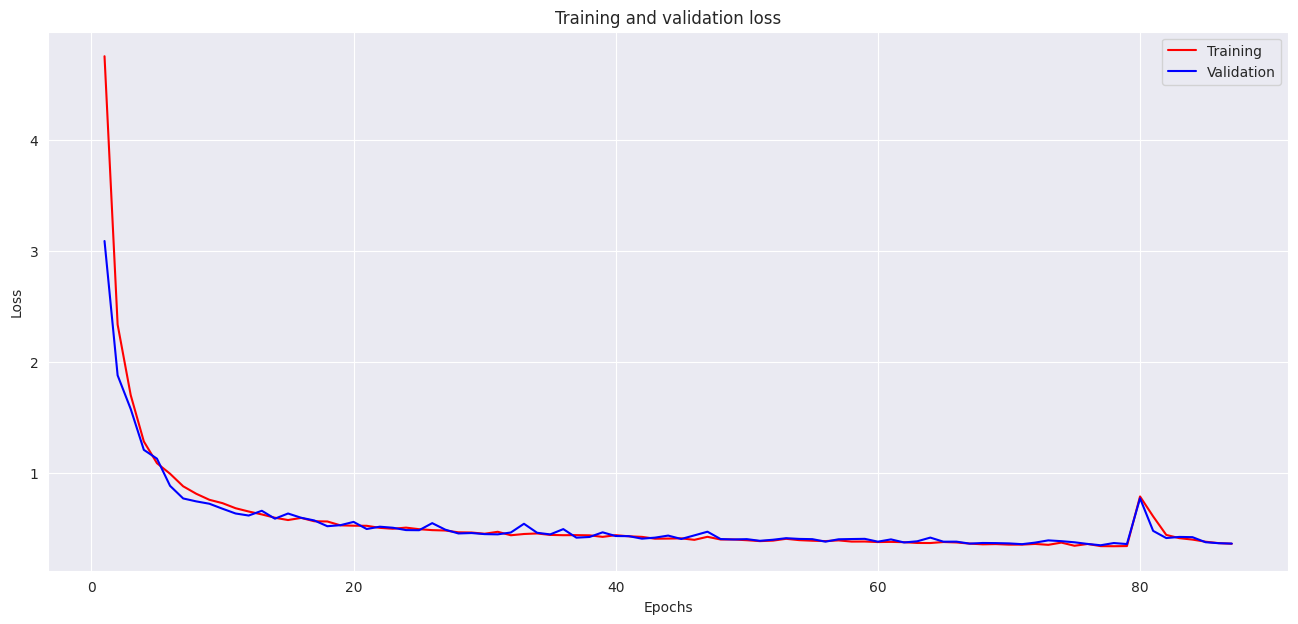

In [ ]:
plt.figure(figsize=(16,7))
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(loss)+1)

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(["Training", "Validation" ])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')

plt.show()

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/trainmod.csv")

In [ ]:
train.shape

(4828800, 7)

1/1 [==============================] - 7s 7s/step


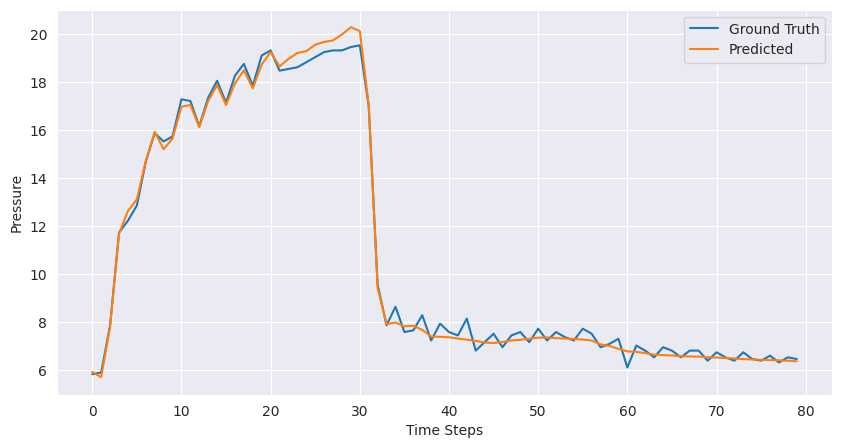

In [ ]:
idx = 1
df_plot = train[train['breath_id'] == idx]
p = model.predict(df_plot[feature_cols].values.reshape(-1, n_steps, n_features))
x = range(len(df_plot))  # Use the length of df_plot for x values
y = df_plot['pressure']
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=y, label="Ground Truth")
sns.lineplot(x=x, y=p.reshape(-1), label="Predicted")
plt.legend()
plt.ylabel("Pressure")
plt.xlabel("Time Steps")
plt.show()

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/testmod.csv")

In [ ]:
test.shape

(1207200, 7)

In [ ]:
feature_cols = ["R","C", "u_in", "u_out"]
n_steps = 80
n_features = len(feature_cols)
target_column_name = 'pressure'  # Replace with the actual target column name

# Assuming "train" is a DataFrame containing your training data
n_samples_test = len(test) // n_steps  # Calculate the number of breaths
y_test = test[target_column_name].values[:n_samples_test * n_steps].reshape(-1, n_steps)
X_test = test[feature_cols].values[:n_samples_test * n_steps].reshape(-1, n_steps, n_features)

print(X_test.shape, y_test.shape)

(15090, 80, 4) (15090, 80)


In [ ]:
from sklearn.metrics import mean_absolute_error

1/1 [==============================] - 12s 12s/step
Mean Absolute Error (MAE): 0.28977367815959165


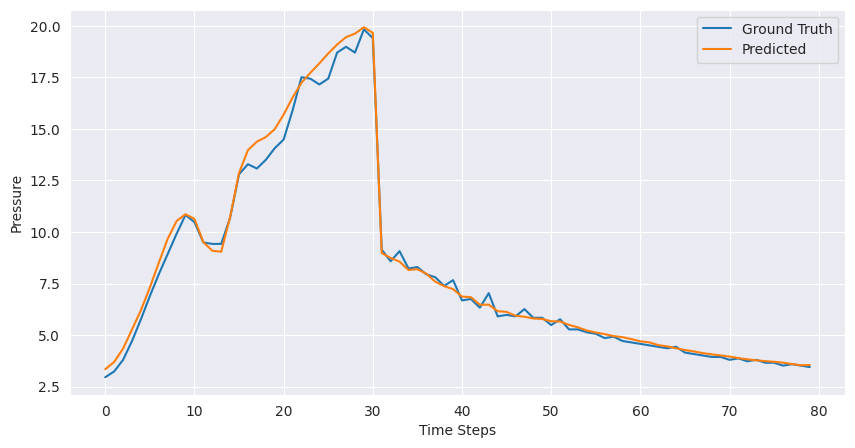

In [ ]:
idx = 100616
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Reshape p to match the shape of y
        p = p.reshape(-1)  # Convert p to a 1D array

        # Calculate MAE
        mae = mean_absolute_error(y, p)

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p, label="Predicted")
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 7s 7s/step
Mean Absolute Error (MAE): 0.1688990200393697


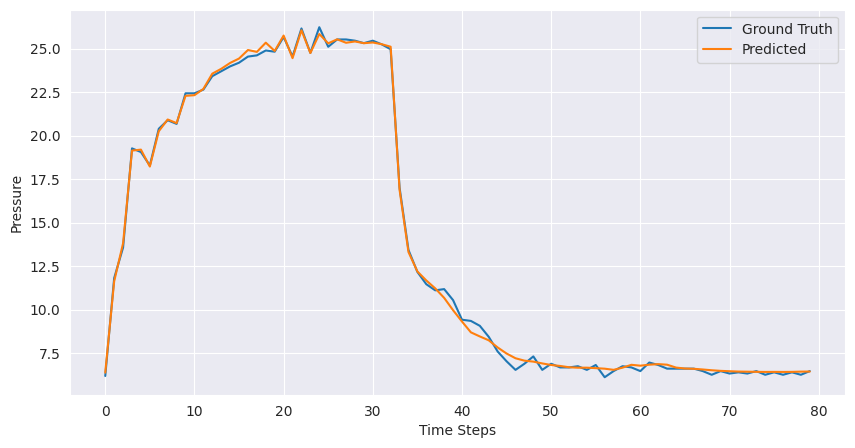

In [ ]:
idx = 122413
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Reshape p to match the shape of y
        p = p.reshape(-1)  # Convert p to a 1D array

        # Calculate MAE
        mae = mean_absolute_error(y, p)

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p, label="Predicted")
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 7s 7s/step
Mean Absolute Error (MAE): 1.330005229035179


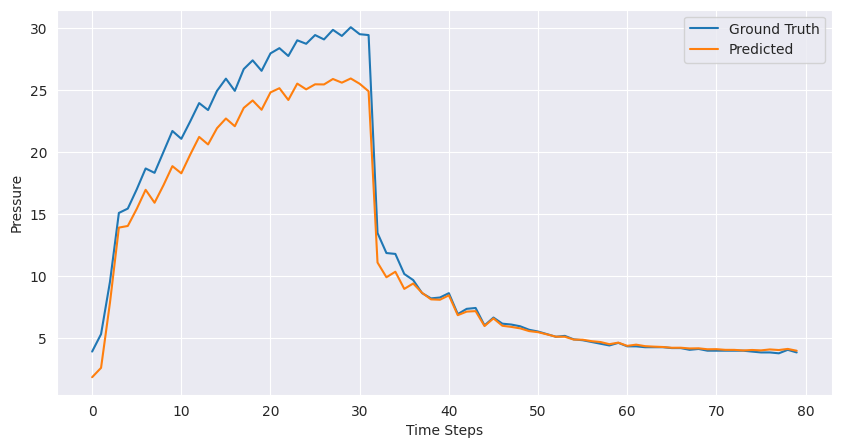

In [ ]:
idx = 125749
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Reshape p to match the shape of y
        p = p.reshape(-1)  # Convert p to a 1D array

        # Calculate MAE
        mae = mean_absolute_error(y, p)

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p, label="Predicted")
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

1/1 [==============================] - 6s 6s/step
Mean Absolute Error (MAE): 0.1586891379722173


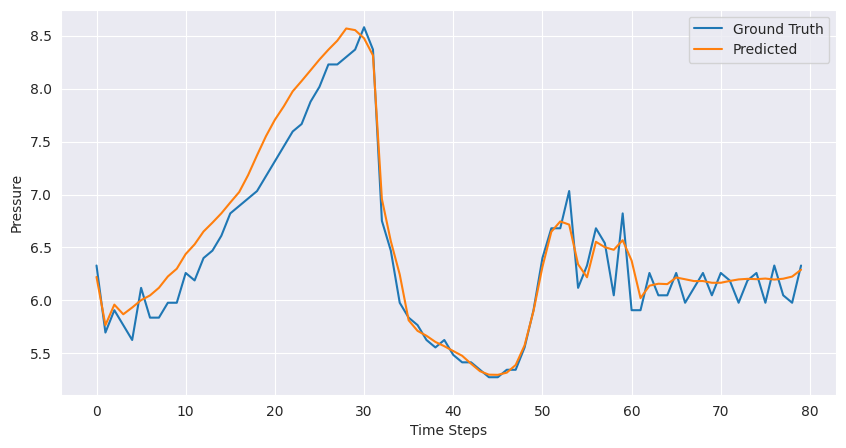

In [ ]:
idx = 125680
df_plot = test[test['breath_id'] == idx]  # Use the test data

# Check if df_plot is empty
if df_plot.empty:
    print("No data found for the specified breath_id.")
else:
    # Assuming your model expects input shape (batch_size, n_steps, n_features)
    n_steps = 80  # Adjust this according to your model's input shape
    n_features = 4  # Adjust this according to your model's input shape
    feature_cols = ['R', 'C', 'u_in', 'u_out']  # Adjust these columns

    # Check if the columns exist in df_plot
    if all(col in df_plot.columns for col in feature_cols):
        input_data = df_plot[feature_cols].values.reshape(1, n_steps, n_features)  # Reshape for prediction

        # Make sure your model is compiled before predicting
        model.compile(optimizer='adam', loss='mae')  # Adjust optimizer and loss

        p = model.predict(input_data)
        x = range(len(df_plot))  # Use the length of df_plot for x values
        y = df_plot['pressure']

        # Reshape p to match the shape of y
        p = p.reshape(-1)  # Convert p to a 1D array

        # Calculate MAE
        mae = mean_absolute_error(y, p)

        print(f"Mean Absolute Error (MAE): {mae}")

        # Plot the results
        plt.figure(figsize=(10, 5))
        sns.lineplot(x=x, y=y, label="Ground Truth")
        sns.lineplot(x=x, y=p, label="Predicted")
        plt.legend()
        plt.ylabel("Pressure")
        plt.xlabel("Time Steps")
        plt.show()
    else:
        print("Some feature columns are missing in the DataFrame.")

In [ ]:
model.save('reduced_complexity_model.keras')

In [ ]:
lm = tf.keras.models.load_model('reduced_complexity_model.keras')

In [ ]:
lm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 80, 600)          732000    
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 80, 500)          1702000   
 onal)                                                           
                                                                 
 bidirectional_38 (Bidirecti  (None, 80, 300)          781200    
 onal)                                                           
                                                                 
 bidirectional_39 (Bidirecti  (None, 80, 200)          320800    
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 80, 50)           